# Notebook on Connecting Coronal Models and In Situ Data in Python

Samuel Badman - 09/29/2023

The goal of this notebook is to show an impactful scientific comparison between in situ data and simple models of the corona can be done entirely within the solar-heliophysics-astrophysics python ecosystem with open source code. We step through (1) making a potential field coronal model, (2) downloading in situ data (here Parker Solar Probe), (3) handling the orbital trajectories and ballistic projection to estimate the relevant source region of the measurements in the corona, (4) display a simple comparison between measured and modeled magnetic field polarity, and measured and modeled solar wind velocity (modeled via magnetic field expansion factor).  

In [1]:
# Run this notebook in the attached conda_env.yml environment

# Built-in
import urllib.request, requests
import os, datetime
from bs4 import BeautifulSoup
def listhtml(url:str, contains:str='', include_url:bool=True):
    ### Function implemented by Andi Kisare in https://github.com/STBadman/cmfpy/

    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')

    out = [node.get('href') for node in soup.find_all('a')]
    if include_url: out = [f'{url}{f}' for f in out if contains in f]
    else: out = [f'{f}' for f in out if contains in f]
    return out

# Standard scientific
import matplotlib.pyplot as plt
import numpy as np

# Astro/solar/helio-specific
import pfsspy
import sunpy.map
import astropy.coordinates
import astropy.units as u
import astrospice
import pyspedas

# Load in PSP Spice Kernels (download happens automatically)
kernels = astrospice.registry.get_kernels('psp','recon') 

Files Downloaded:   0%|          | 0/27 [00:00<?, ?file/s]

### Step 0 : Set date/time interval of interest. 

We will run a coronal model for this date and compare in situ data for a few days around it.

In [2]:
# Default here is Parker Solar Probe Encounter 10 as studied in detail in:
# https://github.com/STBadman/PSP_E10_Sources/tree/main, 
# https://ui.adsabs.harvard.edu/abs/2023JGRA..12831359B/abstract
date = datetime.datetime(2021,11,21)
date_str = f"{date.year:04d}{date.month:02d}{date.day:02d}"
trange = [date-datetime.timedelta(days=4),date+datetime.timedelta(days=4)]

### Step 1 : Producing a Potential Field Source Surface Coronal Model 

Using [pfsspy](https://github.com/dstansby/pfsspy) and following code from https://github.com/STBadman/PSP_Scholars_Tutorial

In [3]:
# Download an ADAPT magnetogram FITS file 
remote_path = f"https://gong.nso.edu//adapt/maps/gong/{date.year:04d}"
filename = listhtml(remote_path, contains=f'{date_str}', include_url=False)[0]
local_path = "."
if not os.path.exists(f"./{filename}") :
    urllib.request.urlretrieve(f"{remote_path}/{filename}", 
                               f"{local_path}/{filename}"
                              )

In [4]:
# Run PFSS Model

# ADAPT maps contain 12 realizations
adaptMapSequence = pfsspy.utils.load_adapt(f"{local_path}/{filename}") 

# Here we average them together, multiply by 1e5 convert to nT (from Gauss),
# and reproject to equal binning in sin(latitude) in the y-axis of the map 
# (which is what pfsspy expects)
adapt_map = pfsspy.utils.car_to_cea( 
    sunpy.map.Map(
        np.mean([m.data for m in adaptMapSequence],axis=0)*1e5,
        adaptMapSequence[0].meta
    )
) 

# Then we run the model with 60 radial grid points out to a 
# source surface height of 2.5Rs
pfss_model = pfsspy.pfss(pfsspy.Input(adapt_map, 60, 2.5))

29-Sep-23 10:58:28: Missing metadata for solar radius: assuming the standard radius of the photosphere.
29-Sep-23 10:58:28: /home/sbadman/anaconda3/lib/python3.9/site-packages/sunpy/map/mapbase.py:628: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs

  obs_coord = self.observer_coordinate



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


### Step 2 :  Download Parker Solar Probe Magnetic Field and Bulk Proton Speed Data

In [5]:
# FIELDS/MAG/RTN_1min
b_dat = pyspedas.psp.fields(trange=trange, 
                               datatype='mag_rtn_1min', 
                               level='l2', time_clip=True,
                               notplot=True)
brtn = b_dat['psp_fld_l2_mag_RTN_1min'] #(View psp.dat.keys() for options)

# SWEAP/SPI/VRTN
v_dat = pyspedas.psp.spi(trange=trange, 
                            datatype='spi_sf00_l3_mom', 
                            level='l3', time_clip=True,
                            notplot=True)
vrtn = v_dat['psp_spi_VEL_RTN_SUN']

29-Sep-23 10:58:31: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2021/
29-Sep-23 10:58:33: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211117_v02.cdf
29-Sep-23 10:58:34: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211118_v02.cdf to psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211118_v02.cdf
29-Sep-23 10:58:34: Download complete: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211118_v02.cdf
29-Sep-23 10:58:34: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211119_v02.cdf to psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211119_v02.cdf
29-Sep-23 10:58:34: Download complete: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211119_v02.cdf
29-Sep-23 10:58:34: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1m

### Step 3 : Compute Spacecraft Trajectories over the timerange of interest

In [6]:
# Generate a list of timestamps to generate the spacecraft positions at
timestamps=[]
t = trange[0]
while t <= trange[-1]:
    timestamps.append(t)
    t+= datetime.timedelta(hours=1) 

# Create the coordinates. We need the spice string "SOLAR PROBE PLUS"
# This produces 
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS',timestamps)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Step 4 : Ballistically Project the Trajectory to the Outer Boundary of the Model

In [7]:
# Define function to do the longitudinal correction
def delta_long(r,vsw=360.*u.km/u.s,omega_sun=14.713*u.deg/u.d,rss=2.5):
    return omega_sun * (r - rss * u.R_sun) / vsw

rss = 2.5*u.R_sun
psp_coords_carr.representation_type = "spherical"
psp_at_source_surface = astropy.coordinates.SkyCoord(
    radius = rss * np.ones(len(psp_coords_carr)),
    ## The projection can also take a varying solar wind speed as an input
    lon = psp_coords_carr.lon + delta_long(psp_coords_carr.radius,rss=rss.value),
    lat = psp_coords_carr.lat,
    frame = sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Step 5 : Trace Field lines in model to get model predictions

In [8]:
seeds = astropy.coordinates.SkyCoord(
    psp_at_source_surface.lon,
    psp_at_source_surface.lat,
    psp_at_source_surface.radius,
    frame = pfss_model.coordinate_frame
)
field_lines = pfss_model.trace(pfsspy.tracing.FortranTracer(max_steps=10000),seeds)

### Step 6 : Extract Predicted In Situ Quantities and Compare with Measurements

In [27]:
polarities = field_lines.polarities
br_pred = pfss_model.get_bvec(field_lines.open_field_lines.source_surface_feet)[:,0]
open_inds = np.where(field_lines.connectivities==1)[0]
expansions = field_lines.expansion_factors

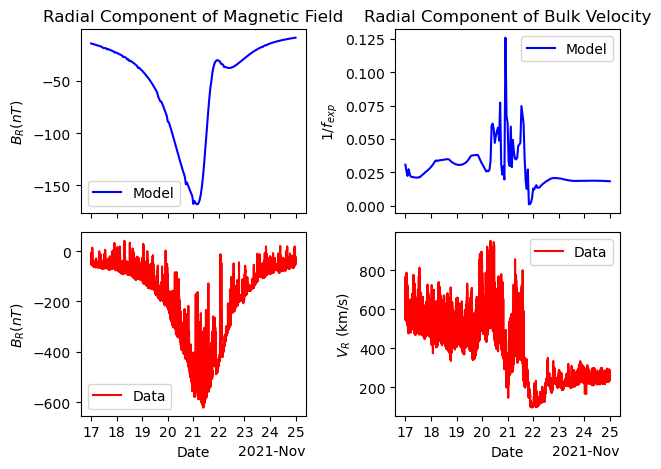

In [41]:
fig,axes = plt.subplots(nrows=2,ncols=2,sharex=True)

axes[0,0].plot(np.array(timestamps)[open_inds],
               br_pred*(pfss_model.grid.rss/psp_coords_carr.radius.to("R_sun").value[open_inds])**2,
               label="Model",color="blue",
              )
axes[1,0].plot(brtn['x'],brtn['y'][:,0],label="Data",color="red")

axes[0,1].plot(timestamps,1/expansions,color="blue",label="Model")
axes[1,1].plot(vrtn['x'],vrtn['y'][:,0],label="Data",color="red")

for ax in axes.flatten() : ax.legend()

plt.tight_layout()

axes[0,0].set_title("Radial Component of Magnetic Field")
axes[0,0].set_ylabel("$B_R (nT)$")
axes[1,0].set_ylabel("$B_R (nT)$")
axes[0,1].set_title("Radial Component of Bulk Velocity")
axes[0,1].set_ylabel("$1/f_{exp}$")
axes[1,1].set_ylabel("$V_R$ (km/s)")

axes[1,0].set_xlabel("Date")
axes[1,1].set_xlabel("Date")

plt.tight_layout()